In [1]:
%%capture
!pip install pyctcdecode
!python -m pip install pypi-kenlm
!pip install jiwer
!pip install bnunicodenormalizer
!pip install -q torchaudio omegaconf

In [2]:
!pip install aksharamukha==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.9 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-none-any.whl size=16417 sha256=21e35ddae4d249509aca6cfe920f919fa830208b30e67f9967397fd4f957bc2a
  Stored in directory: /root/.cache/pip/wheels/50/b7/ba/0af8ddd93a37f8ef7e0a579866276fc3da3a2e6181085ac5d5
Successfully built jaconv


# Imports

In [4]:
import os
import numpy as np
from tqdm.auto import tqdm
from glob import glob
from transformers import AutoFeatureExtractor, pipeline
import pandas as pd
import librosa
import IPython
from datasets import load_metric
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import re
import gc
import wave
from scipy.io import wavfile
import scipy.signal as sps

import torchaudio
from IPython.display import Audio, display
from aksharamukha import transliterate
import random

from bnunicodenormalizer import Normalizer 

tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True,nb_workers=8)


print(torch.__version__)
print(torchaudio.__version__)

bnorm=Normalizer()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
1.11.0
0.11.0


# Configs

In [10]:

class CFG:
    model_name = 'arijitx/wav2vec2-xls-r-300m-bengali' #arijitx/wav2vec2-large-xlsr-bengali,arijitx/wav2vec2-xls-r-300m-bengali, Tahsin-Mayeesha/wav2vec2-bn-300m
    valid_df_path = '../input/dlsprint/validation.csv'
    sample_sub_df_path = '../input/dlsprint/sample_submission.csv'
    valid = "../input/dlsprint/validation_files/"
    test = "../input/dlsprint/test_files/"
    valid_wav = '../input/validation-fileswav-format/validation_files_wav/'
    test_wav = '../input/test-wav-files-dl-sprint/test_files_wav/'
    batch_size = 48
    single_SPEECH_FILE = "../input/dlsprint/validation_files/common_voice_bn_30620258.mp3"
    post_asr_corrector = False
    



# ASR Model

In [11]:
asr = pipeline("automatic-speech-recognition", model=CFG.model_name, device=0)
feature_extractor = AutoFeatureExtractor.from_pretrained(
        CFG.model_name, cache_dir=None, use_auth_token=False
    )
speech, sr = librosa.load(CFG.single_SPEECH_FILE, sr=feature_extractor.sampling_rate)
prediction = asr(
            speech, chunk_length_s=112, stride_length_s=None
        )

pred = prediction["text"]
pred


Downloading:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/309 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/755 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.48G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/57.2M [00:00<?, ?B/s]

'তার পিতার নাম কালীপ্রসন্ন ভট্টাচার্য'

# Actual Audio

In [41]:
IPython.display.Audio(CFG.single_SPEECH_FILE)

# Fix the validation path

In [42]:
import os
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

In [43]:
df = pd.read_csv('../input/dlsprint/validation.csv')
directory ="../input/dlsprint/validation_files/"
df["path"]=df["path"].progress_apply(lambda x:os.path.join(directory,str(x)))
df.head(3)

  0%|          | 0/7747 [00:00<?, ?it/s]

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",3.0,0.0,NaN,NaN,NaN,bn
1,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,6.0,1.0,NaN,NaN,NaN,bn
2,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,3.0,1.0,NaN,NaN,NaN,bn


In [44]:
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",3.0,0.0,NaN,NaN,NaN,bn
1,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,6.0,1.0,NaN,NaN,NaN,bn
2,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,3.0,1.0,NaN,NaN,NaN,bn
3,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকার...,3.0,0.0,NaN,NaN,NaN,bn
4,c07f5f84eaa5f8c8dc964033eb96d4c544d2463c51768b...,../input/dlsprint/validation_files/common_voic...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন...",20.0,1.0,NaN,NaN,NaN,bn
...,...,...,...,...,...,...,...,...,...
7742,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি...,2.0,0.0,NaN,NaN,NaN,bn
7743,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।,2.0,1.0,NaN,NaN,NaN,bn
7744,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?,2.0,0.0,NaN,NaN,NaN,bn
7745,69545be87267c6177baaa60a16a7f474278642c4cec3d8...,../input/dlsprint/validation_files/common_voic...,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।,3.0,0.0,NaN,NaN,NaN,bn


# convert to wav

In [45]:
class bn_asr_Dataset(Dataset):
    '''
    args:
        df      : path of the dataframe
        dir     : directory of sound files
    '''
    def __init__(self,df,dir):
        self.df = pd.read_csv(df)
        self.dir = dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
   
        #speech, _ = librosa.load(self.dir+self.df.path[i], sr=feature_extractor.sampling_rate) 
        path = self.dir+self.df.path[i]
        path = os.path.splitext(path)[0]+'.wav'
        # Read file
        sampling_rate, data = wavfile.read(path)
        # Resample data
        number_of_samples = round(len(data) * float(feature_extractor.sampling_rate) / sampling_rate)
        speech = sps.resample(data, number_of_samples)
        return speech
  


# making prediction on whole validation set

In [46]:
%%time

from tqdm import tqdm

#single image inference
''' 
#super slow inference...

predictions = []
references = []
for i in range(len(df.path)):
    speech, sr = librosa.load(df.path[i], sr=feature_extractor.sampling_rate)
    prediction = asr(speech, chunk_length_s=112, stride_length_s=None)
    pred = prediction["text"]
    predictions.append(pred)
    references.append(df.sentence[i])
    
print(len(predictions),len(references))
'''

df = pd.read_csv(CFG.valid_df_path)

valid_dataset = bn_asr_Dataset(CFG.valid_df_path,CFG.valid_wav)#CFG.valid
predictions = []
references = []
# for i,pred_sentence in enumerate(tqdm(asr(valid_dataset, chunk_length_s=112, stride_length_s=None,batch_size=CFG.batch_size), total=len(valid_dataset))):
#     references.append(df.sentence[i])
#     predictions.append(pred_sentence['text'])
    
# use tqdm for progress bar
for i in tqdm(range(len(valid_dataset))):
    pred = asr(valid_dataset.__getitem__(i), chunk_length_s=112, stride_length_s=None)
    references.append(df.sentence[i])
    predictions.append(pred['text'])

100%|██████████| 7747/7747 [24:32<00:00,  5.26it/s]

CPU times: user 22min 7s, sys: 15 s, total: 22min 22s
Wall time: 24min 32s


In [47]:
torch.cuda.empty_cache() 
gc.collect()
!nvidia-smi

Tue May 23 12:46:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |   2197MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# calculating metric on whole validation set

In [48]:

df = pd.DataFrame(columns=['predictions', 'references'])
df.predictions = predictions
df.references = references


# Unicode Normalizer


In [49]:

def normalize(sen):
    _words = [bnorm(word)['normalized']  for word in sen.split()]
    return " ".join([word for word in _words if word is not None]) 

df.predictions= df.predictions.parallel_apply(lambda x:normalize(x))
df.references= df.references.parallel_apply(lambda x:normalize(x))
df.to_csv('./results.csv',index = False) #use it for error analysis and other stuffs
df.head(10)

,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."
5,এখানে তিনি এয়াকিনসের অধীনে অধ্যয়ন করেছেন,এখানে তিনি এয়াকিনসের অধীনে অধ্যয়ন করেছিলেন।
6,শীতকালীন গেমস এ কোন কোন পদক জিততে পারেনি।,শীতকালীন গেমসে এখনো কোন পদক জিততে পারেনি।
7,অবশেষে তিনি কাবুলে ফিরে আসেন,"অবশেষে, তিনি কাবুলে ফিরে আসেন।"
8,তিনি অ্যাথেলসেএসে চক্রটির শীর্ষ হন,তিনি এথেন্সে এসে সক্রেটিসের শিষ্য হন।
9,তিন বছর বয়সে তার বাবা মারা যান,তিন বছর বয়সে তাঁর বাবা মারা যান।


# Without Post Processing

In [50]:
cer = load_metric("cer")
wer = load_metric("wer")

cer_score = cer.compute(predictions=df.predictions, references=df.references)
print("validation cer_score -> ",cer_score)
wer_score = wer.compute(predictions=df.predictions, references=df.references)
print("validation wer_score -> ",wer_score)

validation cer_score ->  0.09757065617828559
validation wer_score ->  0.3084328285431672


# With  post processing

In [51]:
for i in tqdm(range(len(df.predictions))):
    if(df.predictions[i][-1] == '।'):
        continue
    else:
        df.predictions[i] = df.predictions[i]+'।'

100%|██████████| 7747/7747 [00:00<00:00, 10822.73it/s]


In [52]:
cer_score = cer.compute(predictions=df.predictions, references=df.references)
print("Final validation cer_score -> ",cer_score)
wer_score = wer.compute(predictions=df.predictions, references=df.references)
print("Final validation wer_score -> ",wer_score)

Final validation cer_score ->  0.09252702848203485
Final validation wer_score ->  0.28356483093941126


# Submission with post processing

In [53]:
df = pd.read_csv('../input/dlsprint/sample_submission.csv')
len(df.path)

7747

In [54]:
%%time

test_dataset = bn_asr_Dataset(CFG.sample_sub_df_path,CFG.test_wav)

# for i,prediction in enumerate(tqdm(asr(test_dataset, chunk_length_s=112, stride_length_s=None,batch_size=CFG.batch_size), total=len(test_dataset))):
#     df.sentence[i] = prediction["text"]
    
for i in tqdm(range(len(test_dataset))):
    pred = asr(test_dataset.__getitem__(i), chunk_length_s=112, stride_length_s=None)
    
    #applying simple post processing with error handler
    try:
        if(pred["text"][-1] == '।'):
            df.sentence[i] = pred["text"]
        else:
            df.sentence[i] = pred["text"]+'।'
    except:
        print("predicted text at idx ",i," is -> ",pred["text"])
        df.sentence[i] = pred["text"]+'।'
        
df.sentence=df.sentence.parallel_apply(lambda x:normalize(x)) #unicode normalizer


100%|██████████| 7747/7747 [26:11<00:00,  4.93it/s]


CPU times: user 23min 36s, sys: 18.1 s, total: 23min 54s
Wall time: 26min 45s


In [55]:
df.head(3)

,path,sentence
0,common_voice_bn_31675220.mp3,এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন ...
1,common_voice_bn_31513116.mp3,এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে ...
2,common_voice_bn_31558126.mp3,জন পরিকল্পিত।


In [56]:
df.to_csv('./submission.csv',index = False)
df.sentence[1]

'এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে কুকুর অসুস্থ হয়ে পড়ে।'

In [57]:
IPython.display.Audio('../input/dlsprint/test_files/common_voice_bn_31675220.mp3')

In [58]:
df.sentence[0]

'এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন তিনি।'

In [59]:
df.sentence[80]

'প্রথম শ্রেণির ক্রিকেট প্রতিযোগিতা শেলিল্ডের উদ্বোধনী আসরে অংশ নেয়।'

## ASR correction

In [60]:
!git clone https://github.com/jarobyte91/post_ocr_correction.git
os.chdir('./post_ocr_correction')
!pwd
!ls

fatal: destination path 'post_ocr_correction' already exists and is not an empty directory.
/kaggle/working/post_ocr_correction
LICENSE    build	     evaluate  notebooks       requirements.txt  tests
README.md  download_data.py  lib       pyproject.toml  setup.cfg	 train


In [61]:
!pip install .

Processing /kaggle/working/post_ocr_correction
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for post-ocr-correction: filename=post_ocr_correction-0.0.1-py3-none-any.whl size=6432 sha256=da66f005286e5933a8e62661563648d804182a86ec64ead97084fbdf5b0daaeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6_5rps_/wheels/72/31/2e/2f7f310c7a5d2c12d18796bf8b5e2a7a79569dcc1f6f07f977
Successfully built post-ocr-correction
  Attempting uninstall: post-ocr-correction
    Found existing installation: post-ocr-correction 0.0.1
    Uninstalling post-ocr-correction-0.0.1:
      Successfully uninstalled post-ocr-correction-0.0.1


In [62]:
os.chdir('..')
!ls

__notebook_source__.ipynb  results.csv	submission.csv
post_ocr_correction	   results.txt


In [63]:
results = pd.read_csv('../input/commonvoice-bn-xls-r-metric-calculation/results.csv')
print(len(results))
preds = results.predictions.tolist()
refs = results.references.tolist()
results.head()

7747


,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."


In [64]:
results

,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."
...,...,...
7742,তবে রোগাক্রান্ত পোশাক বিড়ালের মাধ্যমে এটি বেশি...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি ...
7743,পেল ও সহযোগী পেল সংযাগুলোলুকাস ধারার অন্তর্গত,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।
7744,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কি,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?
7745,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতে পছন্দ করে।,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।


In [65]:
# get random 15 samples
random.seed(42)
random_idx = random.sample(range(0, len(results)), 15)
print(random_idx)

[5238, 912, 204, 6074, 2253, 2006, 1828, 1143, 6033, 839, 5543, 6067, 7308, 4467, 712]


In [66]:
# make a new dataframe and save the results with index
new_results = results.iloc[random_idx]
# show the results
new_results
# convert the dataframe to txt file
new_results.to_csv('results.txt', index=False, sep='\t')

In [51]:
# make some visualization of the results
import matplotlib.pyplot as plt
import seaborn as sns

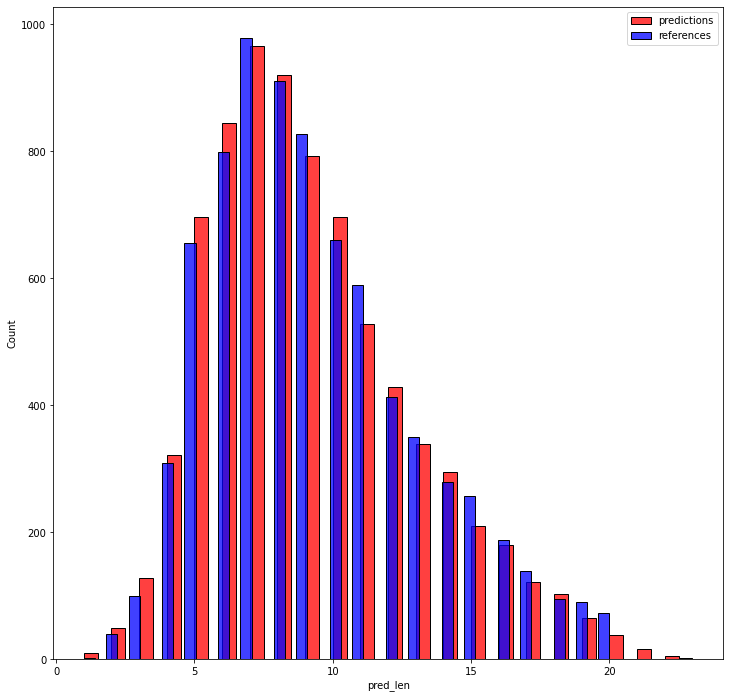

In [68]:
plt.figure(figsize=(12, 12))
results['pred_len'] = results.predictions.apply(lambda x: len(x.split()))
results['ref_len'] = results.references.apply(lambda x: len(x.split()))
sns.histplot(results['pred_len'], color='red', label='predictions')
sns.histplot(results['ref_len'], color='blue', label='references')
plt.legend()
plt.savefig('distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
cer = load_metric("cer")
cer_scores = []
for i in tqdm(range(len(results))):
    cer_scores.append(cer.compute(predictions=[results.predictions[i]], references=[results.references[i]]))
# add the cer scores to the dataframe
results['cer_scores'] = cer_scores

100%|██████████| 7747/7747 [00:28<00:00, 268.23it/s]


In [70]:
wer = load_metric("wer")
# make an empty list to store the wer scores for each sentence
wer_scores = []
for i in tqdm(range(len(results))):
    wer_scores.append(wer.compute(predictions=[results.predictions[i]], references=[results.references[i]]))
# add the wer scores to the dataframe
results['wer_scores'] = wer_scores
results

100%|██████████| 7747/7747 [00:28<00:00, 274.88it/s]


,predictions,references,pred_len,ref_len,cer_scores,wer_scores
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",6,6,0.097561,0.666667
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,7,7,0.250000,0.571429
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,10,10,0.051724,0.300000
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...,9,9,0.209677,0.555556
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন...",14,13,0.012048,0.153846
...,...,...,...,...,...,...
7742,তবে রোগাক্রান্ত পোশাক বিড়ালের মাধ্যমে এটি বেশি...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি ...,8,8,0.039216,0.125000
7743,পেল ও সহযোগী পেল সংযাগুলোলুকাস ধারার অন্তর্গত,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।,7,8,0.102041,0.375000
7744,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কি,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?,9,9,0.042553,0.111111
7745,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতে পছন্দ করে।,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।,7,7,0.024390,0.142857


# Import CSV

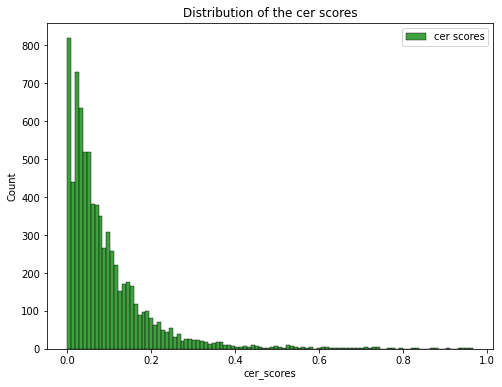

In [71]:
plt.figure(figsize=(8, 6))
# plot the cer scores
sns.histplot(results['cer_scores'], color='green', label='cer scores')
plt.legend()
plt.title('Distribution of the cer scores')
plt.savefig('cer_scores.pdf', dpi=300, bbox_inches='tight')

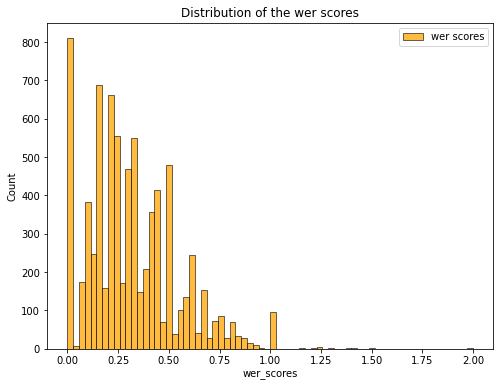

In [72]:
plt.figure(figsize=(8, 6))
# plot the wer scores
sns.histplot(results['wer_scores'], color='orange', label='wer scores')
plt.legend()
plt.title('Distribution of the wer scores')
plt.savefig('wer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 864x864 with 0 Axes>

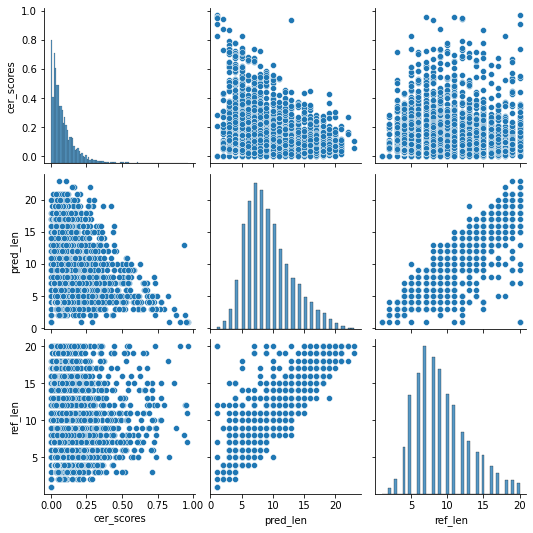

In [73]:
# show a pairplot to show the relationship between the cer scores and the number of words in the sentences
plt.figure(figsize=(12, 12))
sns.pairplot(results[['cer_scores', 'pred_len', 'ref_len']])
plt.savefig('pairplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# generate a heat map to show the relationship between two variables, such as CER scores and pred_len
plt.figure(figsize=(8, 6))
sns.heatmap(results[['cer_scores', 'pred_len']].corr(), annot=True, cmap='Blues')
plt.savefig('heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

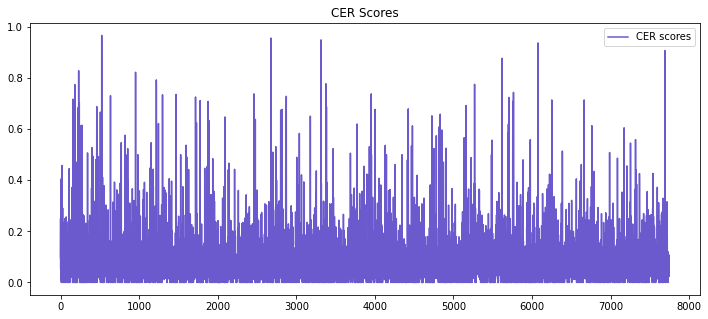

In [74]:
plt.figure(figsize=(12, 5))
# plot the cer scores
plt.plot(results['cer_scores'], color='slateblue', label='CER scores')
plt.legend()
plt.title('CER Scores')
plt.savefig('cer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

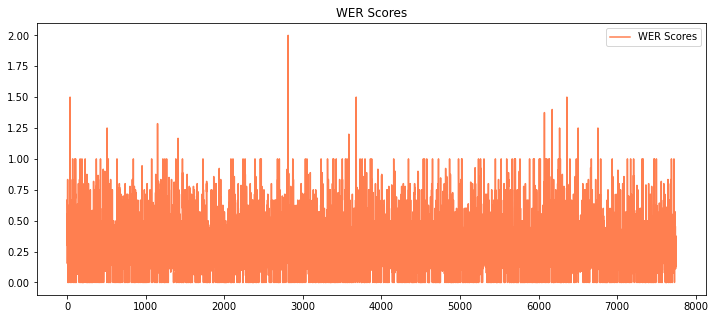

In [75]:
plt.figure(figsize=(12, 5))
# plot the cer scores
plt.plot(results['wer_scores'], color='coral', label='WER Scores')
plt.legend()
plt.title('WER Scores')
plt.savefig('wer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [76]:
#no nan output in results.csv but they exist in train.csv (give it a try)
idx = [i for i, x in zip(range(len(preds)), preds) if not isinstance(x,str)]
for ele in sorted(idx, reverse = True):
    del preds[ele]
    del refs[ele]
len(preds),len(refs)


(7747, 7747)

In [91]:
df

,path,sentence
0,common_voice_bn_31675220.mp3,এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন ...
1,common_voice_bn_31513116.mp3,এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে ...
2,common_voice_bn_31558126.mp3,জন পরিকল্পিত।
3,common_voice_bn_31688693.mp3,বিভিন্ন আন্তর্জাতিক সংস্থার সদর এখানে অবস্থিত ...
4,common_voice_bn_31655323.mp3,অনেকের ধারণা ইন্দিরা রোড বার্তের প্রাক্তমপ্রবন...
...,...,...
7742,common_voice_bn_31630493.mp3,প্রধান কৃষি ফসল নাটমগআলুরিষা শাকসবজি।
7743,common_voice_bn_31630500.mp3,তিনি তার প্রাথমিক শিক্ষা তার গ্রামে পেয়েছেন।
7744,common_voice_bn_31537424.mp3,এ পর্যায়ে তার ইনি দক্ষিণ ক্রিকেই রেকর্ড বিলিকি...
7745,common_voice_bn_31591839.mp3,এছাড়া তিনি আরও অনেকগুলো গ্রন্থ রচনা করেন।


In [95]:
# save results to csv file
results.to_csv('results.csv', index=False)

In [94]:
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Tue May 23 13:24:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   2199MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
from pytorch_beam_search import seq2seq
from post_ocr_correction import correction

for i in range(len(refs)):
    refs[i] = list(refs[i])
    preds[i] = list(preds[i])


# train data and model
source = preds
target = refs
source_index = seq2seq.Index(source)
target_index = seq2seq.Index(target)
X = source_index.text2tensor(source)
Y = target_index.text2tensor(target)
print(source_index)
print(".....")
print(target_index)
print(".....")
print(X)
print(".....")
print(Y)

<Seq2Seq Index with 78 items>
.....
<Seq2Seq Index with 74 items>
.....
tensor([[ 1, 20, 57,  ...,  0,  0,  0],
        [ 1, 35, 53,  ...,  0,  0,  0],
        [ 1, 11,  7,  ...,  0,  0,  0],
        ...,
        [ 1, 22, 44,  ...,  0,  0,  0],
        [ 1, 16, 11,  ...,  0,  0,  0],
        [ 1, 20, 55,  ...,  0,  0,  0]])
.....
tensor([[ 1, 27, 64,  ...,  0,  0,  0],
        [ 1, 42, 60,  ...,  0,  0,  0],
        [ 1, 18, 14,  ...,  0,  0,  0],
        ...,
        [ 1, 29, 51,  ...,  0,  0,  0],
        [ 1, 23, 18,  ...,  0,  0,  0],
        [ 1, 27, 62,  ...,  0,  0,  0]])


In [79]:
%%time
def post_asr_corrector():
    model = seq2seq.Transformer(source_index, target_index,max_sequence_length = 256,dropout = 0.0,embedding_dimension = 192)
    return model

if (CFG.post_asr_corrector):
    print("training POST ASR Corrector...\n")
    epochs = 6000
    batch_size = 1024
    PATH = './post_ASR_corrector.pt'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    X= X.to(device)
    Y= Y.to(device)

    # def post_asr_corrector():
    #     model = seq2seq.Transformer(source_index, target_index,max_sequence_length = len(results)+4,
    #                     embedding_dimension = 512,
    #                     feedforward_dimension = 1024,
    #                     attention_heads = 2,
    #                     encoder_layers = 2,
    #                     decoder_layers = 2)
    #     return model


    model = post_asr_corrector()
    model.to(device)
    model.train()
    model.fit(X, Y, epochs = epochs, progress_bar = 1,batch_size = batch_size)
    model.eval()
    torch.save(model.state_dict(), PATH)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 21.9 µs


# Subtitle

In [12]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
!pip install moviepy pydub
from moviepy.editor import *
import IPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 10.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 44.7 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=695376725c281feda89a0e1c31afffb8bb67d1ba15f2daac0e45c7a128ee393d
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [15]:
# import the news.mp4 and extract its audio from this video
video = VideoFileClip("/kaggle/input/sample-news/news.mp4")
audio = video.audio
# make it usable for pydub
audio.write_audiofile("news.mp3")

MoviePy - Writing audio in news.mp3


MoviePy - Done.


In [16]:
# cut the audio till 45 seconds
audio = AudioSegment.from_mp3("news.mp3")
audio = audio[:45000]
audio.export("news.mp3", format="mp3")

<_io.BufferedRandom name='news.mp3'>

In [17]:
# play the audio file
IPython.display.Audio("news.mp3")

**audio_segment**: The audio segment to split.
**min_silence_len**: The minimum length of silence (in milliseconds) that must be present for a split to occur. In your example, this parameter is set to 500, which means that the audio segment will be split when there is a silence of at least 500 milliseconds.
**silence_thresh**: The threshold (in dBFS) below which the audio is considered silent. In your example, this parameter is set to -30, which means that any part of the audio segment with a volume lower than -30 dBFS will be considered silent.
**keep_silence**: The amount of silence (in milliseconds) to leave at the beginning and end of each chunk. In your example, this parameter is set to 500, which means that each chunk will have 500 milliseconds of silence added at the beginning and end.

*In summary, the split_on_silence function in your example will split the audio segment x into chunks where the silence is at least 500 milliseconds long and has a volume lower than -30 dBFS. Each chunk will have 500 milliseconds of silence added at the beginning and end.*

In [18]:
def milliseconds_to_timecode(milliseconds):
    """Converts milliseconds to timecode in the format hh:mm:ss,mmm"""
    seconds, milliseconds = divmod(milliseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d},{int(milliseconds):03d}"

x = AudioSegment.from_mp3("news.mp3")
chunks = split_on_silence(x, min_silence_len=600, silence_thresh=-30, keep_silence=500)

# Initialize start time to 0
start_time = 0

# Initialize an empty list to store the start and end times of each chunk
timecodes = []

# we will save each chunk of audio in a separate file 
if not os.path.isdir('chunks'):
    os.mkdir('chunks')
else:
    for filename in os.listdir('chunks'):
        os.remove(os.path.join('chunks', filename))
for i, chunk in tqdm(enumerate(chunks)):
    # Calculate the end time of the current chunk
    end_time = start_time + len(chunk)
    
    # Append the start and end times of the current chunk to the timecodes list
    start_timecode = milliseconds_to_timecode(start_time)
    end_timecode = milliseconds_to_timecode(end_time)
    timecodes.append((start_timecode, end_timecode))
    
    # Update the start time for the next chunk
    start_time = end_time
    
    # Export the current chunk as an audio file
    chunk.export(f"chunks/{i}_chunk.mp3", format="mp3")

0it [00:00, ?it/s]

In [19]:
# count the number of chunks from the folder and play them by ipython
# count the number of chunks
path = "chunks"
files = os.listdir(path)
print(f"Total number of chunks: {len(files)}")

# print the chunks filename
for i in range(len(files)):
    print(files[i])
    

Total number of chunks: 16
15_chunk.mp3
12_chunk.mp3
4_chunk.mp3
5_chunk.mp3
2_chunk.mp3
8_chunk.mp3
7_chunk.mp3
6_chunk.mp3
10_chunk.mp3
11_chunk.mp3
3_chunk.mp3
0_chunk.mp3
9_chunk.mp3
1_chunk.mp3
13_chunk.mp3
14_chunk.mp3


In [20]:
# play thefirst chunk with ipython
IPython.display.Audio("chunks/0_chunk.mp3")

In [21]:
timecodes

[('00:00:00,000', '00:00:05,097'),
 ('00:00:05,097', '00:00:09,009'),
 ('00:00:09,009', '00:00:10,540'),
 ('00:00:10,540', '00:00:13,500'),
 ('00:00:13,500', '00:00:14,464'),
 ('00:00:14,464', '00:00:19,965'),
 ('00:00:19,965', '00:00:21,725'),
 ('00:00:21,725', '00:00:22,925'),
 ('00:00:22,925', '00:00:25,305'),
 ('00:00:25,305', '00:00:28,267'),
 ('00:00:28,267', '00:00:29,557'),
 ('00:00:29,557', '00:00:32,092'),
 ('00:00:32,092', '00:00:32,928'),
 ('00:00:32,928', '00:00:34,690'),
 ('00:00:34,690', '00:00:41,149'),
 ('00:00:41,149', '00:00:42,434')]

In [22]:
# make a df to store the path of each chunk and its start and end time
sub_df = pd.DataFrame(columns=['path', 'start_time', 'end_time'])
# Get a list of all chunk files
files = [f for f in os.listdir('chunks') if f.endswith('.mp3')]

# Sort the files by their index
files = sorted(files, key=lambda x: int(x.split('_')[0]))

sub_df['path'] = files
sub_df['start_time'] = [i[0] for i in timecodes]
sub_df['end_time'] = [i[1] for i in timecodes]
sub_df

,path,start_time,end_time
0,0_chunk.mp3,"00:00:00,000","00:00:05,097"
1,1_chunk.mp3,"00:00:05,097","00:00:09,009"
2,2_chunk.mp3,"00:00:09,009","00:00:10,540"
3,3_chunk.mp3,"00:00:10,540","00:00:13,500"
4,4_chunk.mp3,"00:00:13,500","00:00:14,464"
5,5_chunk.mp3,"00:00:14,464","00:00:19,965"
6,6_chunk.mp3,"00:00:19,965","00:00:21,725"
7,7_chunk.mp3,"00:00:21,725","00:00:22,925"
8,8_chunk.mp3,"00:00:22,925","00:00:25,305"
9,9_chunk.mp3,"00:00:25,305","00:00:28,267"


In [23]:
# get the text from the audio chunks using the asr model and save them in df
sub_df['text'] = ''
for i in tqdm(range(len(sub_df))):
    pred = asr('chunks/'+sub_df.path[i], chunk_length_s=112, stride_length_s=None)
    sub_df.text[i] = pred['text']
sub_df

  0%|          | 0/16 [00:00<?, ?it/s]

,path,start_time,end_time,text
0,0_chunk.mp3,"00:00:00,000","00:00:05,097",বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...
1,1_chunk.mp3,"00:00:05,097","00:00:09,009",মঙ্গলবার বিমান বাহিনী প্রধান এয়ার চিফ মার্শাল
2,2_chunk.mp3,"00:00:09,009","00:00:10,540",শেখ আবদুল হান্নান
3,3_chunk.mp3,"00:00:10,540","00:00:13,500",রাষ্ট্রপতির সাথে সাক্ষাৎ করতে বঙ্গভবনে গেলে
4,4_chunk.mp3,"00:00:13,500","00:00:14,464",এ কথা বলেন তিন
5,5_chunk.mp3,"00:00:14,464","00:00:19,965",এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...
6,6_chunk.mp3,"00:00:19,965","00:00:21,725",রাষ্ট্রপতিকে অবহিত করেন
7,7_chunk.mp3,"00:00:21,725","00:00:22,925",বিমান বাহিনী প্রধান
8,8_chunk.mp3,"00:00:22,925","00:00:25,305",দেশের সর্ব ভবত রক্ষার পাশাপাশি
9,9_chunk.mp3,"00:00:25,305","00:00:28,267",আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার


In [24]:
# get an index for sub_df and then generate subtitle from the given sub_df
sub_df.index = [i for i in range(len(sub_df))]
sub_df

,path,start_time,end_time,text
0,0_chunk.mp3,"00:00:00,000","00:00:05,097",বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...
1,1_chunk.mp3,"00:00:05,097","00:00:09,009",মঙ্গলবার বিমান বাহিনী প্রধান এয়ার চিফ মার্শাল
2,2_chunk.mp3,"00:00:09,009","00:00:10,540",শেখ আবদুল হান্নান
3,3_chunk.mp3,"00:00:10,540","00:00:13,500",রাষ্ট্রপতির সাথে সাক্ষাৎ করতে বঙ্গভবনে গেলে
4,4_chunk.mp3,"00:00:13,500","00:00:14,464",এ কথা বলেন তিন
5,5_chunk.mp3,"00:00:14,464","00:00:19,965",এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...
6,6_chunk.mp3,"00:00:19,965","00:00:21,725",রাষ্ট্রপতিকে অবহিত করেন
7,7_chunk.mp3,"00:00:21,725","00:00:22,925",বিমান বাহিনী প্রধান
8,8_chunk.mp3,"00:00:22,925","00:00:25,305",দেশের সর্ব ভবত রক্ষার পাশাপাশি
9,9_chunk.mp3,"00:00:25,305","00:00:28,267",আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার


In [25]:
# generate the subtitle
# create a srt file
with open('subtitle.srt', 'w') as f:
    for i in range(len(sub_df)):
        f.write(str(i+1)+'\n')
        f.write(sub_df.start_time[i]+' --> '+sub_df.end_time[i]+'\n')
        f.write(sub_df.text[i]+'\n')
        f.write('\n')

In [26]:
# show the srt file
with open('subtitle.srt', 'r') as f:
    print(f.read())

1
00:00:00,000 --> 00:00:05,097
বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্যকরণ বাড়ানোর পরামর্শ দিয়েছেন রাষ্ট্রপতি মোহাম্মদ শাহর।

2
00:00:05,097 --> 00:00:09,009
মঙ্গলবার বিমান বাহিনী প্রধান এয়ার চিফ মার্শাল

3
00:00:09,009 --> 00:00:10,540
শেখ আবদুল হান্নান

4
00:00:10,540 --> 00:00:13,500
রাষ্ট্রপতির সাথে সাক্ষাৎ করতে বঙ্গভবনে গেলে

5
00:00:13,500 --> 00:00:14,464
এ কথা বলেন তিন

6
00:00:14,464 --> 00:00:19,965
এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্ষেপ ও বাহিনীর সার্বিক কর্মকাণ্ড সম্পর্কে

7
00:00:19,965 --> 00:00:21,725
রাষ্ট্রপতিকে অবহিত করেন

8
00:00:21,725 --> 00:00:22,925
বিমান বাহিনী প্রধান

9
00:00:22,925 --> 00:00:25,305
দেশের সর্ব ভবত রক্ষার পাশাপাশি

10
00:00:25,305 --> 00:00:28,267
আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার

11
00:00:28,267 --> 00:00:29,557
প্রশংসা করেন রাষ্ট্র

12
00:00:29,557 --> 00:00:32,092
সাক্ষাৎকালে রাষ্ট্রপতির কার্যালয়ের সচিব সম

13
00:00:32,092 --> 00:00:32,928
বড়য়া

14
00:00:32,928 --> 00:00:34,690
সামরিক সচিব মেজর জেনারেল

15
00:0

In [70]:
import requests

# download https://raw.githubusercontent.com/errhythm/ASGwithML/main/actual%20news.srt
url = 'https://raw.githubusercontent.com/errhythm/ASGwithML/main/actual%20news.srt'
r = requests.get(url, allow_redirects=True)
open('actual news.srt', 'wb').write(r.content)



2424

In [71]:
# show the srt file
with open('actual news.srt', 'r') as f:
    print(f.read())

1
00:00:00,000 --> 00:00:05,443
বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্যকরণ বাড়ানোর পরামর্শ দিয়েছেন রাষ্ট্রপতি মোহাম্মদ শাহবুদ্দিন

2
00:00:05,657 --> 00:00:07,700
মঙ্গলবার বিমান বাহিনী প্রধান

3
00:00:07,757 --> 00:00:09,143
এয়ার চিফ মার্শাল

4
00:00:09,229 --> 00:00:10,381
শেখ আবদুল হান্নান

5
00:00:10,386 --> 00:00:12,114
রাষ্ট্রপতির সাথে সাক্ষাৎ

6
00:00:12,171 --> 00:00:13,352
করতে বঙ্গভবনে গেলে

7
00:00:13,357 --> 00:00:14,656
এ কথা বলেন তিনি

8
00:00:14,657 --> 00:00:20,200
এসময় বিমানবাহিনীর উন্নয়নে নেয়া বিভিন্ন পদক্ষেপ ও বাহিনীর সার্বিক কর্মকাণ্ড সম্পর্কে

9
00:00:20,300 --> 00:00:21,743
রাষ্ট্রপতিকে অবহিত করেন

10
00:00:21,840 --> 00:00:23,143
বিমান বাহিনী প্রধান

11
00:00:23,144 --> 00:00:25,385
দেশের সার্বভৌমত্ব রক্ষার পাশাপাশি

12
00:00:25,386 --> 00:00:28,042
আর্থসামাজিক উন্নয়নে বিমান বাহিনীর ভূমিকার

13
00:00:28,043 --> 00:00:29,970
প্রশংসা করেন রাষ্ট্রপতি

14
00:00:29,971 --> 00:00:32,371
সাক্ষাতকালে রাষ্ট্রপতির কার্যালয়ের সচিব

15
00:00:32,372 --> 00:00:33

In [72]:
url = 'https://raw.githubusercontent.com/errhythm/ASGwithML/main/news.srt'
r = requests.get(url, allow_redirects=True)
open('news.srt', 'wb').write(r.content)

2306

In [59]:
# show the srt file
with open('news.srt', 'r') as f:
    print(f.read())

1
00:00:00,000 --> 00:00:04,956
বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্যকরণ বাড়ানোর পরামর্শ দিয়েছেন রাষ্ট্রপতি মোহাম্মদ শাহ

2
00:00:04,956 --> 00:00:07,342
মঙ্গলবার বিমান বাহিনী প্রধান

3
00:00:07,342 --> 00:00:08,849
এয়ার চিফ মার্শাল

4
00:00:08,849 --> 00:00:10,382
শেখ আবদুল হান্নান

5
00:00:10,382 --> 00:00:11,837
রাষ্ট্রপতির সাথে শাখা

6
00:00:11,837 --> 00:00:13,353
তে বঙ্গভবনে গেলে

7
00:00:13,353 --> 00:00:14,315
এ কথা বলেন তিন

8
00:00:14,315 --> 00:00:19,611
এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্ষেপ ও বাহিনীর সার্বিক কর্মকাণ্ড সম্প

9
00:00:19,611 --> 00:00:21,400
রাষ্ট্রপতিকে অবহিত করেন

10
00:00:21,400 --> 00:00:22,626
বিমান বাহিনী প্রধান

11
00:00:22,626 --> 00:00:25,076
দেশের সার্বভমতরক্ষার পাশাপাশি

12
00:00:25,076 --> 00:00:27,970
আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার

13
00:00:27,970 --> 00:00:29,249
প্রশংসা করেন রাষ্ট্র

14
00:00:29,249 --> 00:00:31,098
সাক্ষাতকালী রাষ্ট্রপতির কার্যালয়ের স

15
00:00:31,098 --> 00:00:31,992
পদ বড়ুয়া

16
00:00:3

In [73]:
import re

def get_subtitle_lines(subtitle_text):
    lines = []
    for match in re.finditer(r'\d+\n\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}\n(.+?)\n\n', subtitle_text, re.DOTALL):
        lines.append(match.group(1))
    return lines

In [74]:
# compare the two srt files with jiwer
import jiwer

# read the actual news srt file
with open('actual news.srt', 'r') as f:
    actual_news = get_subtitle_lines(f.read())
    
# read the news srt file
with open('news.srt', 'r') as f:
    news = get_subtitle_lines(f.read())

In [75]:
news

['বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্যকরণ বাড়ানোর পরামর্শ দিয়েছেন রাষ্ট্রপতি মোহাম্মদ শাহ',
 'মঙ্গলবার বিমান বাহিনী প্রধান',
 'এয়ার চিফ মার্শাল',
 'শেখ আবদুল হান্নান',
 'রাষ্ট্রপতির সাথে শাখা',
 'তে বঙ্গভবনে গেলে',
 'এ কথা বলেন তিন',
 'এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্ষেপ ও বাহিনীর সার্বিক কর্মকাণ্ড সম্প',
 'রাষ্ট্রপতিকে অবহিত করেন',
 'বিমান বাহিনী প্রধান',
 'দেশের সার্বভমতরক্ষার পাশাপাশি',
 'আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার',
 'প্রশংসা করেন রাষ্ট্র',
 'সাক্ষাতকালী রাষ্ট্রপতির কার্যালয়ের স',
 'পদ বড়ুয়া',
 'সামরিক সচিব মেজর জেনারেল',
 'এস এম সালাউদ্দিন ইসলাম প্রেস সচিব মো জয়নাল আবেদিন এবং',
 'সচিব সংযুক্ত মো ওয়াহিদুল ইসলাম',
 'উপস্থিত ছিলেন']

In [83]:
def get_subtitle_timecodes(subtitle_text):
    timecodes = []
    for match in re.finditer(r'\d+\n(\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3})\n', subtitle_text):
        timecodes.append(match.group(1))
    return timecodes

In [110]:
# get the timecodes from the actual news srt file
with open('actual news.srt', 'r') as f:
    actual_news_timecodes = get_subtitle_timecodes(f.read())
    
# get the timecodes from the news srt file
with open('news.srt', 'r') as f:
    news_timecodes = get_subtitle_timecodes(f.read())

In [111]:
# split actual_news_timecodes into start and end timecodes
actual_news_start_timecodes = []
actual_news_end_timecodes = []
for i in range(len(actual_news_timecodes)):
    actual_news_start_timecodes.append(actual_news_timecodes[i].split(' --> ')[0])
    actual_news_end_timecodes.append(actual_news_timecodes[i].split(' --> ')[1])

In [112]:
# split news_timecodes into start and end timecodes
news_start_timecodes = []
news_end_timecodes = []
for i in range(len(news_timecodes)):
    news_start_timecodes.append(news_timecodes[i].split(' --> ')[0])
    news_end_timecodes.append(news_timecodes[i].split(' --> ')[1])

In [113]:
# make a dataframe to store the actual news and news
news_df = pd.DataFrame(columns=['actual_news', 'news', 'actual_news_start_timecodes', 'actual_news_end_timecodes', 'news_start_timecodes', 'news_end_timecodes'])
news_df.actual_news = actual_news
news_df.news = news
news_df.actual_news_start_timecodes = actual_news_start_timecodes
news_df.actual_news_end_timecodes = actual_news_end_timecodes
news_df.news_start_timecodes = news_start_timecodes
news_df.news_end_timecodes = news_end_timecodes
news_df

,actual_news,news,actual_news_start_timecodes,actual_news_end_timecodes,news_start_timecodes,news_end_timecodes
0,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,"00:00:00,000","00:00:05,443","00:00:00,000","00:00:04,956"
1,মঙ্গলবার বিমান বাহিনী প্রধান,মঙ্গলবার বিমান বাহিনী প্রধান,"00:00:05,657","00:00:07,700","00:00:04,956","00:00:07,342"
2,এয়ার চিফ মার্শাল,এয়ার চিফ মার্শাল,"00:00:07,757","00:00:09,143","00:00:07,342","00:00:08,849"
3,শেখ আবদুল হান্নান,শেখ আবদুল হান্নান,"00:00:09,229","00:00:10,381","00:00:08,849","00:00:10,382"
4,রাষ্ট্রপতির সাথে সাক্ষাৎ,রাষ্ট্রপতির সাথে শাখা,"00:00:10,386","00:00:12,114","00:00:10,382","00:00:11,837"
5,করতে বঙ্গভবনে গেলে,তে বঙ্গভবনে গেলে,"00:00:12,171","00:00:13,352","00:00:11,837","00:00:13,353"
6,এ কথা বলেন তিনি,এ কথা বলেন তিন,"00:00:13,357","00:00:14,656","00:00:13,353","00:00:14,315"
7,এসময় বিমানবাহিনীর উন্নয়নে নেয়া বিভিন্ন পদক্...,এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...,"00:00:14,657","00:00:20,200","00:00:14,315","00:00:19,611"
8,রাষ্ট্রপতিকে অবহিত করেন,রাষ্ট্রপতিকে অবহিত করেন,"00:00:20,300","00:00:21,743","00:00:19,611","00:00:21,400"
9,বিমান বাহিনী প্রধান,বিমান বাহিনী প্রধান,"00:00:21,840","00:00:23,143","00:00:21,400","00:00:22,626"


In [86]:
# get the wer score
wer = load_metric("wer")

wer_scores = []
for i in tqdm(range(len(news_df))):
    wer_scores.append(wer.compute(predictions=[news_df.news[i]], references=[news_df.actual_news[i]]))
news_df['wer_scores'] = wer_scores
news_df

  0%|          | 0/19 [00:00<?, ?it/s]

,actual_news,news,actual_news_timecodes,news_timecodes,wer_scores
0,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,"00:00:00,000 --> 00:00:05,443","00:00:00,000 --> 00:00:04,956",0.076923
1,মঙ্গলবার বিমান বাহিনী প্রধান,মঙ্গলবার বিমান বাহিনী প্রধান,"00:00:05,657 --> 00:00:07,700","00:00:04,956 --> 00:00:07,342",0.000000
2,এয়ার চিফ মার্শাল,এয়ার চিফ মার্শাল,"00:00:07,757 --> 00:00:09,143","00:00:07,342 --> 00:00:08,849",0.000000
3,শেখ আবদুল হান্নান,শেখ আবদুল হান্নান,"00:00:09,229 --> 00:00:10,381","00:00:08,849 --> 00:00:10,382",0.000000
4,রাষ্ট্রপতির সাথে সাক্ষাৎ,রাষ্ট্রপতির সাথে শাখা,"00:00:10,386 --> 00:00:12,114","00:00:10,382 --> 00:00:11,837",0.333333
5,করতে বঙ্গভবনে গেলে,তে বঙ্গভবনে গেলে,"00:00:12,171 --> 00:00:13,352","00:00:11,837 --> 00:00:13,353",0.333333
6,এ কথা বলেন তিনি,এ কথা বলেন তিন,"00:00:13,357 --> 00:00:14,656","00:00:13,353 --> 00:00:14,315",0.250000
7,এসময় বিমানবাহিনীর উন্নয়নে নেয়া বিভিন্ন পদক্...,এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...,"00:00:14,657 --> 00:00:20,200","00:00:14,315 --> 00:00:19,611",0.181818
8,রাষ্ট্রপতিকে অবহিত করেন,রাষ্ট্রপতিকে অবহিত করেন,"00:00:20,300 --> 00:00:21,743","00:00:19,611 --> 00:00:21,400",0.000000
9,বিমান বাহিনী প্রধান,বিমান বাহিনী প্রধান,"00:00:21,840 --> 00:00:23,143","00:00:21,400 --> 00:00:22,626",0.000000


In [87]:
# get the cer score
cer = load_metric("cer")

cer_scores = []
for i in tqdm(range(len(news_df))):
    cer_scores.append(cer.compute(predictions=[news_df.news[i]], references=[news_df.actual_news[i]]))
news_df['cer_scores'] = cer_scores
news_df


  0%|          | 0/19 [00:00<?, ?it/s]

,actual_news,news,actual_news_timecodes,news_timecodes,wer_scores,cer_scores
0,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...,"00:00:00,000 --> 00:00:05,443","00:00:00,000 --> 00:00:04,956",0.076923,0.066038
1,মঙ্গলবার বিমান বাহিনী প্রধান,মঙ্গলবার বিমান বাহিনী প্রধান,"00:00:05,657 --> 00:00:07,700","00:00:04,956 --> 00:00:07,342",0.000000,0.000000
2,এয়ার চিফ মার্শাল,এয়ার চিফ মার্শাল,"00:00:07,757 --> 00:00:09,143","00:00:07,342 --> 00:00:08,849",0.000000,0.000000
3,শেখ আবদুল হান্নান,শেখ আবদুল হান্নান,"00:00:09,229 --> 00:00:10,381","00:00:08,849 --> 00:00:10,382",0.000000,0.000000
4,রাষ্ট্রপতির সাথে সাক্ষাৎ,রাষ্ট্রপতির সাথে শাখা,"00:00:10,386 --> 00:00:12,114","00:00:10,382 --> 00:00:11,837",0.333333,0.208333
5,করতে বঙ্গভবনে গেলে,তে বঙ্গভবনে গেলে,"00:00:12,171 --> 00:00:13,352","00:00:11,837 --> 00:00:13,353",0.333333,0.111111
6,এ কথা বলেন তিনি,এ কথা বলেন তিন,"00:00:13,357 --> 00:00:14,656","00:00:13,353 --> 00:00:14,315",0.250000,0.066667
7,এসময় বিমানবাহিনীর উন্নয়নে নেয়া বিভিন্ন পদক্...,এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...,"00:00:14,657 --> 00:00:20,200","00:00:14,315 --> 00:00:19,611",0.181818,0.058140
8,রাষ্ট্রপতিকে অবহিত করেন,রাষ্ট্রপতিকে অবহিত করেন,"00:00:20,300 --> 00:00:21,743","00:00:19,611 --> 00:00:21,400",0.000000,0.000000
9,বিমান বাহিনী প্রধান,বিমান বাহিনী প্রধান,"00:00:21,840 --> 00:00:23,143","00:00:21,400 --> 00:00:22,626",0.000000,0.000000


In [88]:
# overall wer score
wer.compute(predictions=news_df.news.tolist(), references=news_df.actual_news.tolist())


0.1978021978021978

In [89]:
# overall cer score
cer.compute(predictions=news_df.news.tolist(), references=news_df.actual_news.tolist())

0.07366771159874608

## Subtitle Visualization

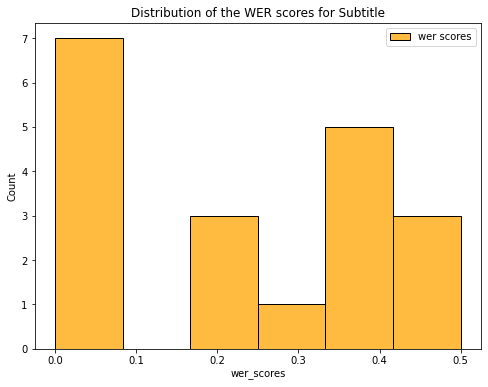

In [90]:
# get a distribution of the wer scores
plt.figure(figsize=(8, 6))
sns.histplot(news_df['wer_scores'], color='orange', label='wer scores')
plt.legend()
plt.title('Distribution of the WER scores for Subtitle')
plt.savefig('subtitle_wer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

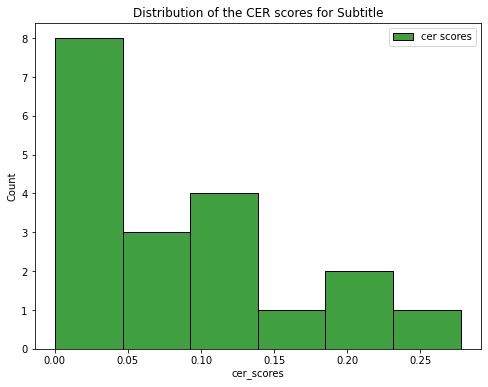

In [91]:
# get a distribution of the cer scores
plt.figure(figsize=(8, 6))
sns.histplot(news_df['cer_scores'], color='green', label='cer scores')
plt.legend()
plt.title('Distribution of the CER scores for Subtitle')
plt.savefig('subtitle_cer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

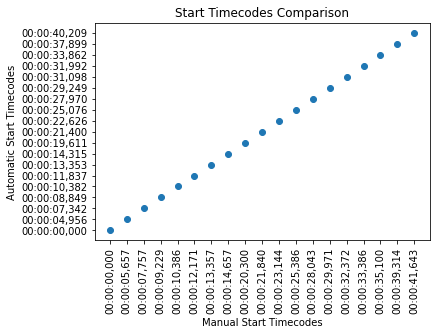

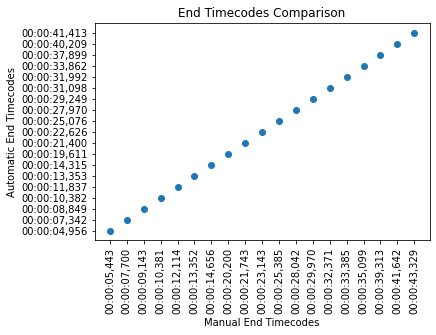

In [132]:
import matplotlib.pyplot as plt

plt.scatter(news_df['actual_news_start_timecodes'], news_df['news_start_timecodes'])
plt.xlabel('Manual Start Timecodes')
plt.ylabel('Automatic Start Timecodes')
plt.title('Start Timecodes Comparison')
plt.xticks(rotation=90)
plt.show()

plt.scatter(news_df['actual_news_end_timecodes'], news_df['news_end_timecodes'])
plt.xlabel('Manual End Timecodes')
plt.ylabel('Automatic End Timecodes')
plt.title('End Timecodes Comparison')
plt.xticks(rotation=90)
plt.show()


In [143]:
def timecode_to_milliseconds(timecode):
    hh, mm, ss_ms = timecode.split(':')
    ss, ms = map(int, ss_ms.split(','))
    return (int(hh) * 3600 + int(mm) * 60 + ss) * 1000 + ms


In [144]:
# make a new df named miliseconds_df to store the actual_news_end_timecodes and news_end_timecodes in miliseconds
miliseconds_df = pd.DataFrame(columns=['actual_news_end_timecodes', 'news_end_timecodes'])
miliseconds_df.actual_news_end_timecodes = news_df.actual_news_end_timecodes
miliseconds_df.news_end_timecodes = news_df.news_end_timecodes
miliseconds_df

,actual_news_end_timecodes,news_end_timecodes
0,"00:00:05,443","00:00:04,956"
1,"00:00:07,700","00:00:07,342"
2,"00:00:09,143","00:00:08,849"
3,"00:00:10,381","00:00:10,382"
4,"00:00:12,114","00:00:11,837"
5,"00:00:13,352","00:00:13,353"
6,"00:00:14,656","00:00:14,315"
7,"00:00:20,200","00:00:19,611"
8,"00:00:21,743","00:00:21,400"
9,"00:00:23,143","00:00:22,626"


In [145]:
# convert the actual_news_end_timecodes and news_end_timecodes to miliseconds
for i in range(len(miliseconds_df)):
    miliseconds_df.actual_news_end_timecodes[i] = timecode_to_milliseconds(miliseconds_df.actual_news_end_timecodes[i])
    miliseconds_df.news_end_timecodes[i] = timecode_to_milliseconds(miliseconds_df.news_end_timecodes[i])
miliseconds_df

,actual_news_end_timecodes,news_end_timecodes
0,5443,4956
1,7700,7342
2,9143,8849
3,10381,10382
4,12114,11837
5,13352,13353
6,14656,14315
7,20200,19611
8,21743,21400
9,23143,22626


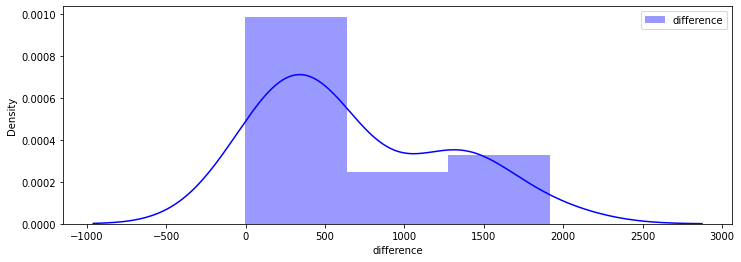

In [154]:
# Get the difference between the actual_news_end_timecodes and news_end_timecodes and plot them
miliseconds_df['difference'] = miliseconds_df.actual_news_end_timecodes - miliseconds_df.news_end_timecodes
plt.figure(figsize=(12, 4))
sns.distplot(miliseconds_df['difference'], color='blue', label='difference')
plt.legend()
# plt.title('Distribution of the difference between the Manual Subtitle vs Generated Subtitle Time Code')
plt.savefig('timesubdifference.pdf', dpi=300, bbox_inches='tight')
plt.show()